Привет! Это мой второй пет-проект в качестве аналитика данных. Дата выполнения: 2023-08-02.

На прошедших выходных закончился турнир по дисциплине Dota 2 под названием Riyadh Masters 2023. Победителем стала Team Spirit, представляющая СНГ. Порадуемся за коллектив!

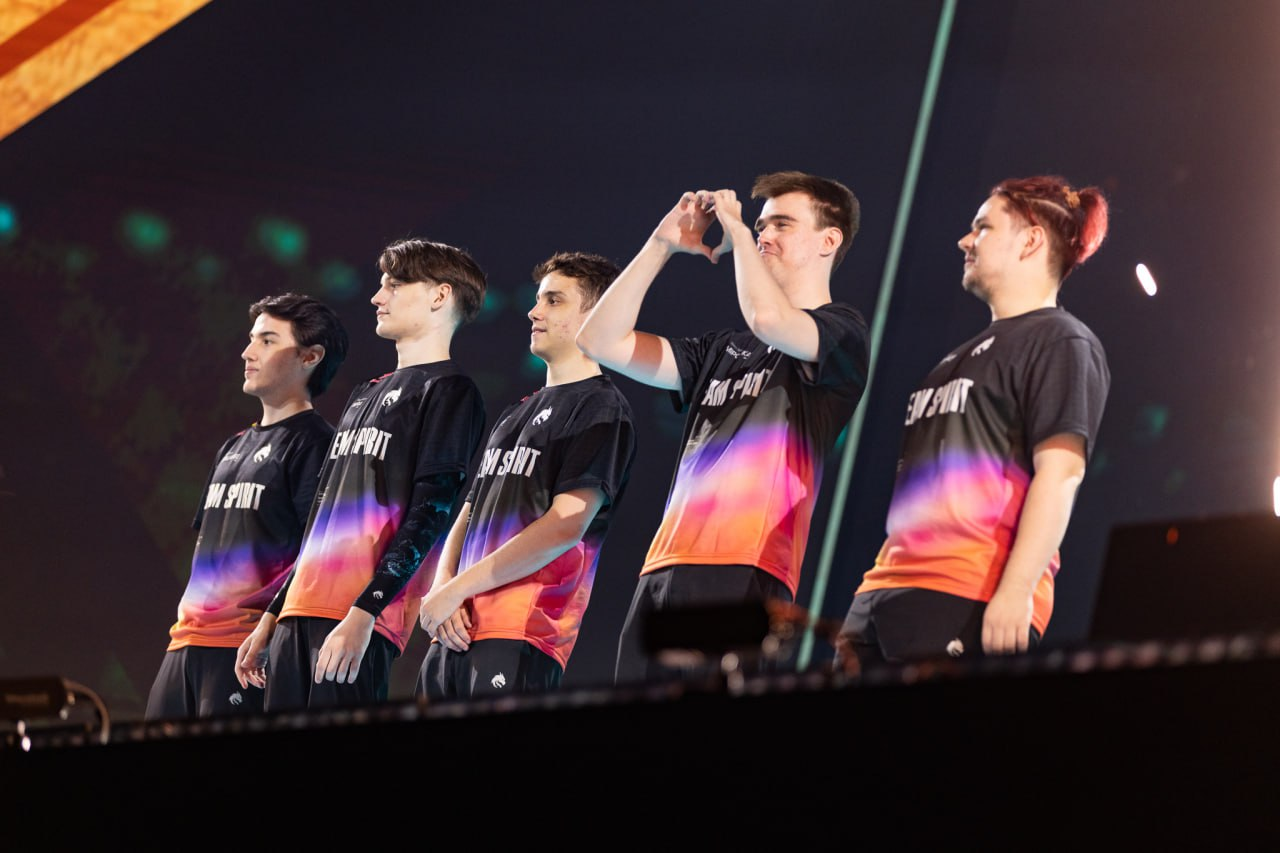

Dota 2 динамично меняющаяся киберспортивная дисциплина, где каждый новый турнир отличается от предыдущего.

Участвовшим в турнире командам важно понимать, почему они заняли какое-то определенное место на нем, чтобы в дальнейшем улучшить свою игру.

Для этого им нужна статистика по используемым героям, а также знание ключевых моментов в игре, которые способствуют победе.

Подготовим такие данные по прошедшему турниру, используя API https://www.opendota.com/ и документацию https://docs.opendota.com/.

Начинаем с импортирования необходимых для проекта библиотек.

In [89]:
import requests
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np

В первую очередь понадобится перечень героев Dota 2 с их id для анализа частоты их использования и процента их побед.

Список героев с их id доступен по ссылке: https://api.opendota.com/api/heroes. Воспользуемся библиотекой ``requests``, которая является стандартным инструментом для составления HTTP-запросов в Python.

In [90]:
heroes_str = requests.get('https://api.opendota.com/api/heroes')
print(heroes_str.content.decode('UTF-8'))

[{"id":1,"name":"npc_dota_hero_antimage","localized_name":"Anti-Mage","primary_attr":"agi","attack_type":"Melee","roles":["Carry","Escape","Nuker"],"legs":2},{"id":2,"name":"npc_dota_hero_axe","localized_name":"Axe","primary_attr":"str","attack_type":"Melee","roles":["Initiator","Durable","Disabler","Carry"],"legs":2},{"id":3,"name":"npc_dota_hero_bane","localized_name":"Bane","primary_attr":"all","attack_type":"Ranged","roles":["Support","Disabler","Nuker","Durable"],"legs":4},{"id":4,"name":"npc_dota_hero_bloodseeker","localized_name":"Bloodseeker","primary_attr":"agi","attack_type":"Melee","roles":["Carry","Disabler","Nuker","Initiator"],"legs":2},{"id":5,"name":"npc_dota_hero_crystal_maiden","localized_name":"Crystal Maiden","primary_attr":"int","attack_type":"Ranged","roles":["Support","Disabler","Nuker"],"legs":2},{"id":6,"name":"npc_dota_hero_drow_ranger","localized_name":"Drow Ranger","primary_attr":"agi","attack_type":"Ranged","roles":["Carry","Disabler","Pusher"],"legs":2},{"

Извлечем данные.

In [91]:
heroes_list = json.loads(heroes_str.content)

type(heroes_list)

list

На основе полученного сформируем датафрейм.

In [92]:
heroes = pd.DataFrame({
    'hero_id': [i['id'] for i in heroes_list],
    'hero_name': [i['localized_name'] for i in heroes_list],
    'hero_primary_attr': [i['primary_attr'] for i in heroes_list]
    })

heroes.head()

,hero_id,hero_name,hero_primary_attr
0,1,Anti-Mage,agi
1,2,Axe,str
2,3,Bane,all
3,4,Bloodseeker,agi
4,5,Crystal Maiden,int


Далее нужно узнать статистику всех матчей турнира.

Согласно документации, это можно сделать по запросу: https://api.opendota.com/api/leagues/{league_id}/matches, где ``{league_id}`` - уникальный идентификатор турнира.

Понадобится список всех турниров по дисциплине с их id. Согласно документации, получить его можно по запросу: https://api.opendota.com/api/leagues.

In [93]:
tournaments_str = requests.get('https://api.opendota.com/api/leagues')

tournaments_list = json.loads(tournaments_str.content)

Нам нужно в этом списке найти уникальный идентификатор турнира, название которого Riyadh Masters 2023 by Gamers8.

In [94]:
for i in tournaments_list:
    if i['name'] == 'Riyadh Masters 2023 by Gamers8':
        print(i['leagueid'])

15475


Итак, у нас есть id турнира, теперь можно получить информацию о всех его матчах.

In [95]:
matches_str = requests.get('https://api.opendota.com/api/leagues/15475/matches')

matches_list = json.loads(matches_str.content)

type(matches_list)

list

Выведем данные об одном из матчей, посмотрим, какая информация нам пригодится.

In [96]:
print(matches_list[0])

{'match_id': 7257852466, 'match_seq_num': 6104539183, 'radiant_win': True, 'start_time': 1690386021, 'duration': 3664, 'tower_status_radiant': 1792, 'tower_status_dire': 0, 'barracks_status_radiant': 52, 'barracks_status_dire': 0, 'cluster': 161, 'first_blood_time': 76, 'lobby_type': 1, 'human_players': 10, 'leagueid': 15475, 'positive_votes': 0, 'negative_votes': 0, 'game_mode': 2, 'engine': 1, 'picks_bans': [{'is_pick': False, 'hero_id': 91, 'team': 1, 'order': 0}, {'is_pick': False, 'hero_id': 33, 'team': 0, 'order': 1}, {'is_pick': False, 'hero_id': 108, 'team': 1, 'order': 2}, {'is_pick': False, 'hero_id': 4, 'team': 0, 'order': 3}, {'is_pick': True, 'hero_id': 61, 'team': 1, 'order': 4}, {'is_pick': True, 'hero_id': 120, 'team': 0, 'order': 5}, {'is_pick': True, 'hero_id': 128, 'team': 0, 'order': 6}, {'is_pick': True, 'hero_id': 39, 'team': 1, 'order': 7}, {'is_pick': False, 'hero_id': 89, 'team': 1, 'order': 8}, {'is_pick': False, 'hero_id': 58, 'team': 0, 'order': 9}, {'is_pic

Для себя выделим следующие элементы:

``match_id`` - уникальный идентификатор каждого матча;

``radiant_win`` - победила ли сторона Света;

``duration`` - продолжительность игры в секундах.

``picks_bans`` - выбранные и заблокированные для выбора герои;

``radiant_gold_adv`` - преимущество стороны Света в золоте в каждую минуту игры;

``radiant_score`` - количество убийств, совершенных героями стороны Света;

``dire_score`` - количество убийств, совершенных героями стороны Тьмы;

``chat`` - сообщения во внутриигровом чате.

Начнем с подсчета общего количества игр на турнире.

In [97]:
print('Общее количество игр на турнире:', len(matches_list))

Общее количество игр на турнире: 236


Далее вычислим количесто побед сторон Света и Тьмы.

In [98]:
radiant_win_count = 0
dire_win_count = 0

for i in matches_list:
    if i['radiant_win'] == True:
        radiant_win_count += 1
    else:
        dire_win_count += 1

print('Количество побед стороны Света:', radiant_win_count, '\nКоличество побед стороны Тьмы:', dire_win_count)

Количество побед стороны Света: 114 
Количество побед стороны Тьмы: 122


Построим круговую диаграмму для наглядности.

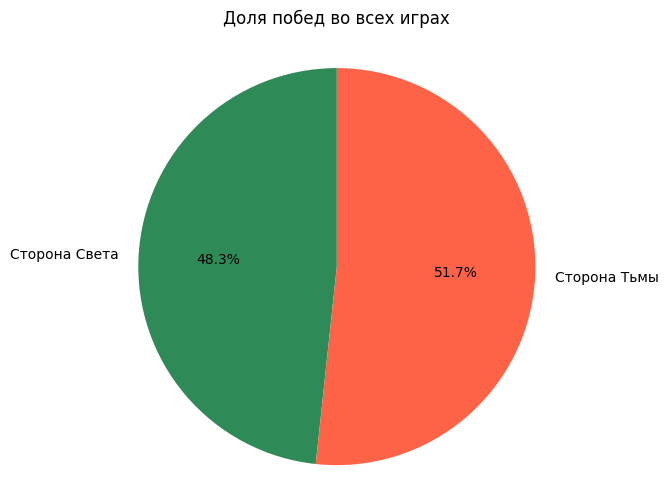

In [99]:
vals = [radiant_win_count, dire_win_count]
labels = ['Сторона Света', 'Сторона Тьмы']

fig, ax = plt.subplots()
ax.pie(vals, labels=labels, autopct = '%1.1f%%', startangle = 90, colors = ['seagreen', 'tomato'])
ax.axis("scaled")
plt.suptitle('Доля побед во всех играх')
plt.tight_layout()

Видно, что доли побед сторон практически равны.

Далее посмотрим, как распределились игры по своей продолжительности. Разобьем их на группы:

- менее 20 минут;
- от 20 до 30 минут;
- от 30 до 40 минут;
- от 40 до 50 минут;
- от 50 до 60 минут;
- от 60 минут.

In [100]:
duration_20 = 0
duration_20_30 = 0
duration_30_40 = 0
duration_40_50 = 0
duration_50_60 = 0
duration_60 = 0

for i in matches_list:
    if i['duration'] // 60 < 20:
        duration_20 += 1
    elif i['duration'] // 60 >= 20 and i['duration'] // 60 < 30:
        duration_20_30 += 1
    elif i['duration'] // 60 >= 30 and i['duration'] // 60 < 40:
        duration_30_40 += 1
    elif i['duration'] // 60 >= 40 and i['duration'] // 60 < 50:
        duration_40_50 += 1
    elif i['duration'] // 60 >= 50 and i['duration'] // 60 < 60:
        duration_50_60 += 1
    elif i['duration'] // 60 >= 60:
        duration_60 += 1

print('менее 20 минут:', duration_20, '\nот 20 до 30 минут:', duration_20_30, '\nот 30 до 40 минут:', duration_30_40, '\nот 40 до 50 минут:', duration_40_50, '\nот 50 до 60 минут:', duration_50_60, '\nот 60 минут:', duration_60)

менее 20 минут: 4 
от 20 до 30 минут: 35 
от 30 до 40 минут: 104 
от 40 до 50 минут: 63 
от 50 до 60 минут: 18 
от 60 минут: 12


Построим столбчатую диаграмму с распределением игр по продолжительности.

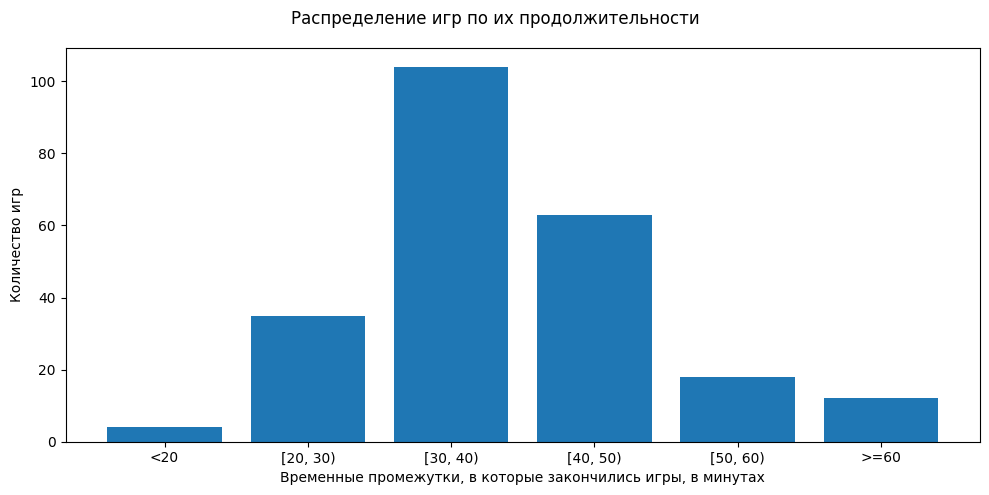

In [101]:
plt.rcParams["figure.figsize"] = (10,5)

groups = ['<20', '[20, 30)', '[30, 40)', '[40, 50)', '[50, 60)', '>=60']
counts = [duration_20, duration_20_30, duration_30_40, duration_40_50, duration_50_60, duration_60]
plt.bar(groups, counts)
plt.suptitle('Распределение игр по их продолжительности')
plt.xlabel('Временные промежутки, в которые закончились игры, в минутах')
plt.ylabel('Количество игр')
plt.tight_layout()

Группы от 30 до 40 и от 40 до 50 минут оказались с наибольшим количеством игр. Интересно, что эти длительности близки к распространенному сериальному формату.

Далее соберем данные о стадии выбора героев, чтобы в дальнейшем определить самых популярных. Определим количество выборов и запретов выбора героев. Это значение постоянно для каждой игры.

In [102]:
len(matches_list[0]['picks_bans'])

24

In [103]:
picks_bans = []

for i in matches_list:
    if i['picks_bans'] is not None:
        picks_bans.append(i['picks_bans'])

len(picks_bans)

235

Похоже, что в одной игре данные о выборе и запрете выбора героев не сохранились.

In [104]:
bans_id = []
picks_id = []

for i in picks_bans:
    for j in i:
        if j['is_pick'] == False:
            bans_id.append(j['hero_id'])
        else:
            picks_id.append(j['hero_id'])

count_b_p = len(picks_bans) * len(picks_bans[0])

print('Количество запретов выбора героя:', len(bans_id), '\nКоличество выборов героя:', len(picks_id), '\nПроверка:', count_b_p - len(bans_id) - len(picks_id))

Количество запретов выбора героя: 3289 
Количество выборов героя: 2350 
Проверка: 1


Данные об одном выборе или запрете выбора не сохранились, на общую картину это не повлияет.

Теперь необходимо посчитать количества по каждому герою. С этим поможет функция numpy.unique().

In [105]:
heroes_bans = np.unique(bans_id, return_counts = True)

heroes_picks = np.unique(picks_id, return_counts = True)

Получены массивы с id героев и количеством их выборов/запретов выбора. Создадим датафреймы.

In [106]:
bans = pd.DataFrame({
    'hero_id': heroes_bans[0],
    'bans': heroes_bans[1]
    })

bans.head()

,hero_id,bans
0,1,33
1,2,7
2,4,120
3,5,2
4,6,49


In [107]:
picks = pd.DataFrame({
    'hero_id': heroes_picks[0],
    'picks': heroes_picks[1]
    })

picks.head()

,hero_id,picks
0,1,4
1,2,11
2,3,3
3,4,37
4,5,15


Объединим вместе ``heroes``, ``bans``, ``picks``.

In [108]:
heroes_b_p = heroes.merge(bans, on = 'hero_id', how = 'left').merge(picks, on = 'hero_id', how = 'left').fillna(0)

heroes_b_p['bans'] = heroes_b_p['bans'].astype(int)

heroes_b_p['picks'] = heroes_b_p['picks'].astype(int)

heroes_b_p

,hero_id,hero_name,hero_primary_attr,bans,picks
0,1,Anti-Mage,agi,33,4
1,2,Axe,str,7,11
2,3,Bane,all,0,3
3,4,Bloodseeker,agi,120,37
4,5,Crystal Maiden,int,2,15
...,...,...,...,...,...
119,129,Mars,str,49,43
120,135,Dawnbreaker,str,1,2
121,136,Marci,all,0,1
122,137,Primal Beast,str,65,36


Добавим столбцы с процентами выборов и запретов выбора героев в общем количестве игр.

In [109]:
heroes_b_p['banrate'] = heroes_b_p['bans'] / len(picks_bans) * 100

heroes_b_p['pickrate'] = heroes_b_p['picks'] / len(picks_bans) * 100

heroes_b_p['banrate'] = heroes_b_p['banrate'].round(2)

heroes_b_p['pickrate'] = heroes_b_p['pickrate'].round(2)

heroes_b_p

,hero_id,hero_name,hero_primary_attr,bans,picks,banrate,pickrate
0,1,Anti-Mage,agi,33,4,14.04,1.70
1,2,Axe,str,7,11,2.98,4.68
2,3,Bane,all,0,3,0.00,1.28
3,4,Bloodseeker,agi,120,37,51.06,15.74
4,5,Crystal Maiden,int,2,15,0.85,6.38
...,...,...,...,...,...,...,...
119,129,Mars,str,49,43,20.85,18.30
120,135,Dawnbreaker,str,1,2,0.43,0.85
121,136,Marci,all,0,1,0.00,0.43
122,137,Primal Beast,str,65,36,27.66,15.32


Следующая цель - посчитать процент побед каждого героя при его выборе.

Сначала посчитаем количество побед, которые были одержаны при выборе героя.

In [110]:
picks_winrate_id = []

for i in matches_list:
    if i['radiant_win'] == True and i['picks_bans'] is not None:
        for j in i['picks_bans']:
            if j['team'] == 0 and j['is_pick'] == True:
                picks_winrate_id.append(j['hero_id'])
    elif i['radiant_win'] == False and i['picks_bans'] is not None:
        for j in i['picks_bans']:
            if j['team'] == 1 and j['is_pick'] == True:
                picks_winrate_id.append(j['hero_id'])

picks_winrate = np.unique(picks_winrate_id, return_counts = True)

picks_winrate_count = pd.DataFrame({
    'hero_id': picks_winrate[0],
    'wins': picks_winrate[1]
    })

picks_winrate_count.head()

,hero_id,wins
0,1,3
1,2,4
2,3,2
3,4,17
4,5,9


In [111]:
heroes_b_p = heroes_b_p.merge(picks_winrate_count, on = 'hero_id', how = 'left').fillna(0)

heroes_b_p

,hero_id,hero_name,hero_primary_attr,bans,picks,banrate,pickrate,wins
0,1,Anti-Mage,agi,33,4,14.04,1.70,3.0
1,2,Axe,str,7,11,2.98,4.68,4.0
2,3,Bane,all,0,3,0.00,1.28,2.0
3,4,Bloodseeker,agi,120,37,51.06,15.74,17.0
4,5,Crystal Maiden,int,2,15,0.85,6.38,9.0
...,...,...,...,...,...,...,...,...
119,129,Mars,str,49,43,20.85,18.30,18.0
120,135,Dawnbreaker,str,1,2,0.43,0.85,0.0
121,136,Marci,all,0,1,0.00,0.43,1.0
122,137,Primal Beast,str,65,36,27.66,15.32,18.0


In [112]:
heroes_b_p['wins'] = heroes_b_p['wins'].astype(int)

heroes_b_p['winrate'] = heroes_b_p['wins'] / heroes_b_p['picks'] * 100

heroes_b_p['winrate'] = heroes_b_p['winrate'].round(2)

heroes_b_p

,hero_id,hero_name,hero_primary_attr,bans,picks,banrate,pickrate,wins,winrate
0,1,Anti-Mage,agi,33,4,14.04,1.70,3,75.00
1,2,Axe,str,7,11,2.98,4.68,4,36.36
2,3,Bane,all,0,3,0.00,1.28,2,66.67
3,4,Bloodseeker,agi,120,37,51.06,15.74,17,45.95
4,5,Crystal Maiden,int,2,15,0.85,6.38,9,60.00
...,...,...,...,...,...,...,...,...,...
119,129,Mars,str,49,43,20.85,18.30,18,41.86
120,135,Dawnbreaker,str,1,2,0.43,0.85,0,0.00
121,136,Marci,all,0,1,0.00,0.43,1,100.00
122,137,Primal Beast,str,65,36,27.66,15.32,18,50.00


Сделаем то же самое, только для поражений. Заодно проверим получившиеся результаты.

In [113]:
picks_loserate_id = []

for i in matches_list:
    if i['radiant_win'] == True and i['picks_bans'] is not None:
        for j in i['picks_bans']:
            if j['team'] == 1 and j['is_pick'] == True:
                picks_loserate_id.append(j['hero_id'])
    elif i['radiant_win'] == False and i['picks_bans'] is not None:
        for j in i['picks_bans']:
            if j['team'] == 0 and j['is_pick'] == True:
                picks_loserate_id.append(j['hero_id'])

picks_loserate = np.unique(picks_loserate_id, return_counts = True)

picks_loserate_count = pd.DataFrame({
    'hero_id': picks_loserate[0],
    'loses': picks_loserate[1]
    })

picks_loserate_count.head()

,hero_id,loses
0,1,1
1,2,7
2,3,1
3,4,20
4,5,6


In [114]:
heroes_b_p = heroes_b_p.merge(picks_loserate_count, on = 'hero_id', how = 'left').fillna(0)

heroes_b_p

,hero_id,hero_name,hero_primary_attr,bans,picks,banrate,pickrate,wins,winrate,loses
0,1,Anti-Mage,agi,33,4,14.04,1.70,3,75.00,1.0
1,2,Axe,str,7,11,2.98,4.68,4,36.36,7.0
2,3,Bane,all,0,3,0.00,1.28,2,66.67,1.0
3,4,Bloodseeker,agi,120,37,51.06,15.74,17,45.95,20.0
4,5,Crystal Maiden,int,2,15,0.85,6.38,9,60.00,6.0
...,...,...,...,...,...,...,...,...,...,...
119,129,Mars,str,49,43,20.85,18.30,18,41.86,25.0
120,135,Dawnbreaker,str,1,2,0.43,0.85,0,0.00,2.0
121,136,Marci,all,0,1,0.00,0.43,1,100.00,0.0
122,137,Primal Beast,str,65,36,27.66,15.32,18,50.00,18.0


In [115]:
heroes_b_p['loses'] = heroes_b_p['loses'].astype(int)

heroes_b_p['loserate'] = heroes_b_p['loses'] / heroes_b_p['picks'] * 100

heroes_b_p['loserate'] = heroes_b_p['loserate'].fillna(0).round(2)

heroes_b_p

,hero_id,hero_name,hero_primary_attr,bans,picks,banrate,pickrate,wins,winrate,loses,loserate
0,1,Anti-Mage,agi,33,4,14.04,1.70,3,75.00,1,25.00
1,2,Axe,str,7,11,2.98,4.68,4,36.36,7,63.64
2,3,Bane,all,0,3,0.00,1.28,2,66.67,1,33.33
3,4,Bloodseeker,agi,120,37,51.06,15.74,17,45.95,20,54.05
4,5,Crystal Maiden,int,2,15,0.85,6.38,9,60.00,6,40.00
...,...,...,...,...,...,...,...,...,...,...,...
119,129,Mars,str,49,43,20.85,18.30,18,41.86,25,58.14
120,135,Dawnbreaker,str,1,2,0.43,0.85,0,0.00,2,100.00
121,136,Marci,all,0,1,0.00,0.43,1,100.00,0,0.00
122,137,Primal Beast,str,65,36,27.66,15.32,18,50.00,18,50.00


Определим героев, которые ни разу не были выбраны, ни разу не были запрещены для выбора и оба условия вместе.

In [116]:
heroes_b_p[heroes_b_p['picks'] == 0]

,hero_id,hero_name,hero_primary_attr,bans,picks,banrate,pickrate,wins,winrate,loses,loserate
21,22,Zeus,int,1,0,0.43,0.0,0,0.0,0,0.0
26,28,Slardar,str,1,0,0.43,0.0,0,0.0,0,0.0
33,35,Sniper,agi,1,0,0.43,0.0,0,0.0,0,0.0
42,44,Phantom Assassin,agi,0,0,0.00,0.0,0,0.0,0,0.0
48,50,Dazzle,all,0,0,0.00,0.0,0,0.0,0,0.0
55,57,Omniknight,str,0,0,0.00,0.0,0,0.0,0,0.0
94,96,Centaur Warrunner,str,0,0,0.00,0.0,0,0.0,0,0.0
100,102,Abaddon,all,0,0,0.00,0.0,0,0.0,0,0.0
115,121,Grimstroke,int,0,0,0.00,0.0,0,0.0,0,0.0


In [117]:
heroes_b_p[heroes_b_p['bans'] == 0]

,hero_id,hero_name,hero_primary_attr,bans,picks,banrate,pickrate,wins,winrate,loses,loserate
2,3,Bane,all,0,3,0.0,1.28,2,66.67,1,33.33
15,16,Sand King,all,0,1,0.0,0.43,1,100.00,0,0.00
19,20,Vengeful Spirit,all,0,2,0.0,0.85,0,0.00,2,100.00
22,23,Kunkka,str,0,1,0.0,0.43,0,0.00,1,100.00
25,27,Shadow Shaman,int,0,1,0.0,0.43,0,0.00,1,100.00
30,32,Riki,agi,0,1,0.0,0.43,0,0.00,1,100.00
40,42,Wraith King,str,0,2,0.0,0.85,1,50.00,1,50.00
42,44,Phantom Assassin,agi,0,0,0.0,0.00,0,0.00,0,0.00
48,50,Dazzle,all,0,0,0.0,0.00,0,0.00,0,0.00
55,57,Omniknight,str,0,0,0.0,0.00,0,0.00,0,0.00


In [118]:
heroes_b_p[(heroes_b_p['picks'] == 0) & (heroes_b_p['bans'] == 0)]

,hero_id,hero_name,hero_primary_attr,bans,picks,banrate,pickrate,wins,winrate,loses,loserate
42,44,Phantom Assassin,agi,0,0,0.0,0.0,0,0.0,0,0.0
48,50,Dazzle,all,0,0,0.0,0.0,0,0.0,0,0.0
55,57,Omniknight,str,0,0,0.0,0.0,0,0.0,0,0.0
94,96,Centaur Warrunner,str,0,0,0.0,0.0,0,0.0,0,0.0
100,102,Abaddon,all,0,0,0.0,0.0,0,0.0,0,0.0
115,121,Grimstroke,int,0,0,0.0,0.0,0,0.0,0,0.0


Героям, которые попали в последнюю таблицу, явно требуется усиление. Если в период до следующего турнира они не будут улучшены, то командам целесообразно игнорировать их в тренировочном процессе.

Представим наглядно героев с лучшими показателями на турнире. Из-за того, что всего 124 героя, то разобъем их на группы по главному атрибуту:
- ``agi`` - ловкость;
- ``str`` - сила;
- ``int`` - интеллект;
- ``all`` - универсал.

Также было принято решение ограничить выборку: на графике представлены только те герои, сумма выборов и запретов выборов которых больше или равна 30, что составляет примерно 0,5% от общего количества выборов и запретов выбора на турнире.

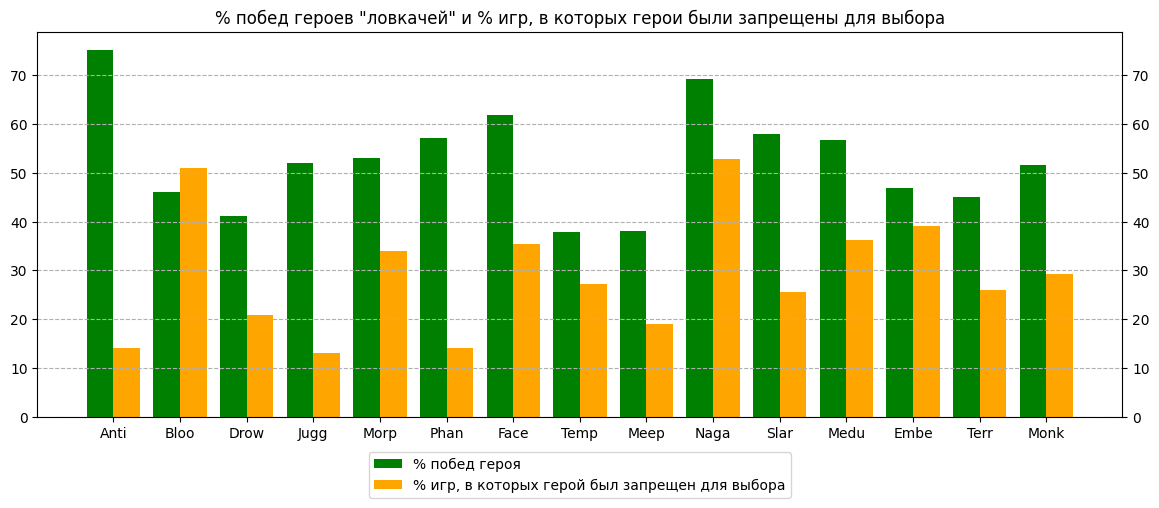

In [119]:
plt.rcParams["figure.figsize"] = (14,5)

x_labels = []
agi_heroes = heroes_b_p[(heroes_b_p['hero_primary_attr'] == 'agi') & (heroes_b_p['bans'] + heroes_b_p['picks'] >= 30)]['hero_name']
for i in agi_heroes:
    x_labels.append(i[0:4])

g1 = heroes_b_p[(heroes_b_p['hero_primary_attr'] == 'agi') & (heroes_b_p['bans'] + heroes_b_p['picks'] >= 30)]['winrate']
g2 = heroes_b_p[(heroes_b_p['hero_primary_attr'] == 'agi') & (heroes_b_p['bans'] + heroes_b_p['picks'] >= 30)]['banrate']
width = 0.4
x = np.arange(len(x_labels))

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, g1, width, label='% побед героя', color = 'green')
rects2 = ax.bar(x + width/2, g2, width, label='% игр, в которых герой был запрещен для выбора', color = 'orange')
ax.set_title('% побед героев "ловкачей" и % игр, в которых герои были запрещены для выбора')
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.grid(axis = 'y', linestyle = '--')
ax.legend(loc = 'center', bbox_to_anchor=(0.5, -0.15))
plt.tick_params(axis='y', left = True, right = True, labelleft=True, labelright=True)

Глядя на получившуюся диаграмму, можно сделать следующие выводы:
- Anti-Mage, Juggernaut и Phantom Lancer при проценте побед выше 50% реже других оказывались запрещены для выбора. Это указывает на недооцененность героя в реалиях турнира;
- Bloodseeker, Drow Ranger, Templar Assassin, Meepo, Ember Spirit, Terrorblade при проценте побед ниже 50% были запрещены для выбора чаще, чем ранее рассмотренная тройка. Это указывает на их переоцененность;
- Morphling, Faceless Void, Naga Siren, Slark, Medusa, Monkey King имеют процент побед выше 50%, а также их выбор часто запрещался. Это указывает на верную оценку героев командами.

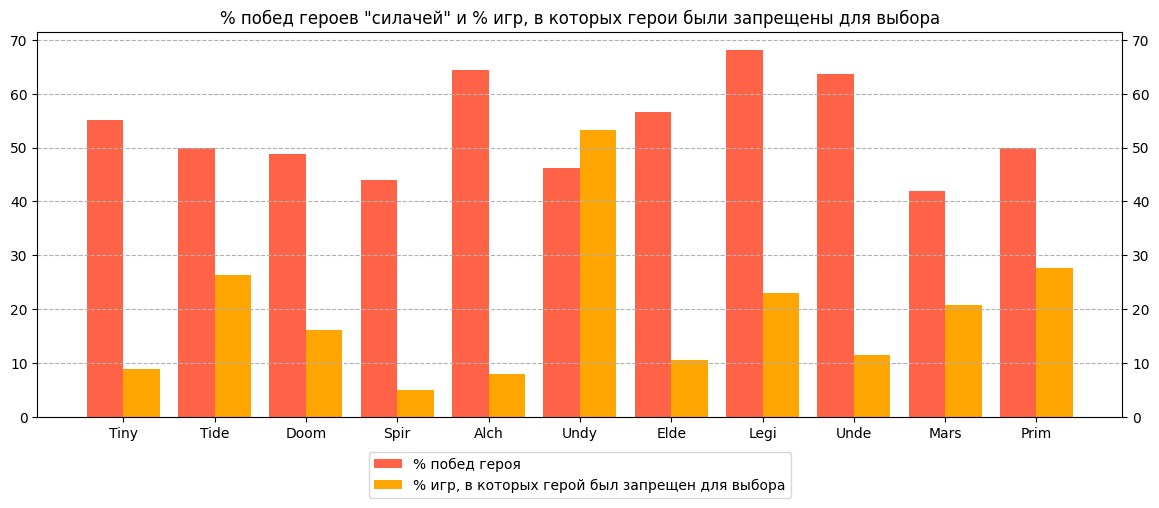

In [120]:
plt.rcParams["figure.figsize"] = (14,5)

x_labels = []
agi_heroes = heroes_b_p[(heroes_b_p['hero_primary_attr'] == 'str') & (heroes_b_p['bans'] + heroes_b_p['picks'] >= 30)]['hero_name']
for i in agi_heroes:
    x_labels.append(i[0:4])

g1 = heroes_b_p[(heroes_b_p['hero_primary_attr'] == 'str') & (heroes_b_p['bans'] + heroes_b_p['picks'] >= 30)]['winrate']
g2 = heroes_b_p[(heroes_b_p['hero_primary_attr'] == 'str') & (heroes_b_p['bans'] + heroes_b_p['picks'] >= 30)]['banrate']
width = 0.4
x = np.arange(len(x_labels))

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, g1, width, label='% побед героя', color = 'tomato')
rects2 = ax.bar(x + width/2, g2, width, label='% игр, в которых герой был запрещен для выбора', color = 'orange')
ax.set_title('% побед героев "силачей" и % игр, в которых герои были запрещены для выбора')
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.grid(axis = 'y', linestyle = '--')
ax.legend(loc = 'center', bbox_to_anchor=(0.5, -0.15))
plt.tick_params(axis='y', left = True, right = True, labelleft=True, labelright=True)

По получившейся диаграмме видно, что:
- Tiny, Alchemist, Elden Titan, Legion Commander, Underlord были недооценены командами на протяжении турнира - больше половины игр выигрывала команда, которая их выбирала, при этом количество запретов для выбора этих героев небольшое;
- Tidehunter, Doom, Undying, Mars, Primal Beast имеют процент побед меньше 50%, однако чаще запрещались для выбора, чем ранее перечисленные герои. Это говорит о их переоценке командами.
- Spirit Breaker - верно оцененный командами герой - низкий процент побед, меньшее количество запретов для выбора.

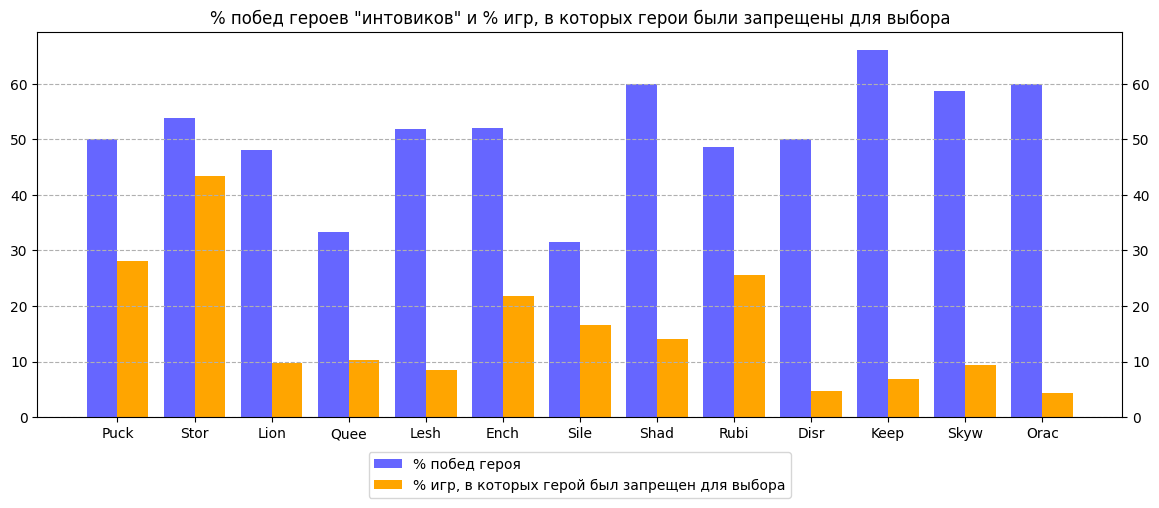

In [121]:
plt.rcParams["figure.figsize"] = (14,5)

x_labels = []
agi_heroes = heroes_b_p[(heroes_b_p['hero_primary_attr'] == 'int') & (heroes_b_p['bans'] + heroes_b_p['picks'] >= 30)]['hero_name']
for i in agi_heroes:
    x_labels.append(i[0:4])

g1 = heroes_b_p[(heroes_b_p['hero_primary_attr'] == 'int') & (heroes_b_p['bans'] + heroes_b_p['picks'] >= 30)]['winrate']
g2 = heroes_b_p[(heroes_b_p['hero_primary_attr'] == 'int') & (heroes_b_p['bans'] + heroes_b_p['picks'] >= 30)]['banrate']
width = 0.4
x = np.arange(len(x_labels))

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, g1, width, label='% побед героя', color = 'blue', alpha = 0.6)
rects2 = ax.bar(x + width/2, g2, width, label='% игр, в которых герой был запрещен для выбора', color = 'orange')
ax.set_title('% побед героев "интовиков" и % игр, в которых герои были запрещены для выбора')
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.grid(axis = 'y', linestyle = '--')
ax.legend(loc = 'center', bbox_to_anchor=(0.5, -0.15))
plt.tick_params(axis='y', left = True, right = True, labelleft=True, labelright=True)

Анализируем следующую диаграмму, с ней сложнее - необходимо помнить, что большинство героев "интовиков" выполняют роль поддержки, частота запретов для их выбора в среднем меньше.
- Puck, Storm Spirit - не являются героями поддержки, имеют высокий процент побед и игр, в которых были запрещены для выбора. Верная оценка героев командами;
- Lion, Queen of Pain, Silencer, Disruptor - низкий процент побед и редко были запрещены для выбора. Верная оценка героев командами;
- Enchantress, Rubick - высокий процент побед (у Rubick процент меньше 50%, однако это самый популярный герой турнира), высокая частота запретов для выбора. Верная оценка героев командами.
- Leshrack, Shadow Shaman, Keeper of the Light, Skywrath Mahe, Oracle - высокий процент побед, низкий процент игр, в которых были запрещены для выбора. Недооценка героев командами, несмотря на то, что герои исполняют роль поддержки.

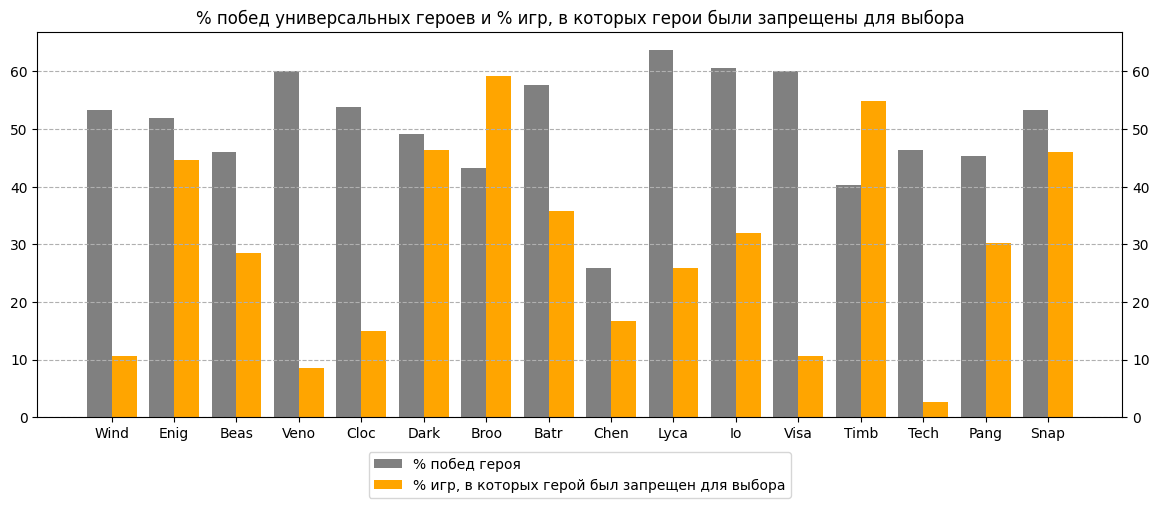

In [122]:
plt.rcParams["figure.figsize"] = (14,5)

x_labels = []
agi_heroes = heroes_b_p[(heroes_b_p['hero_primary_attr'] == 'all') & (heroes_b_p['bans'] + heroes_b_p['picks'] >= 30)]['hero_name']
for i in agi_heroes:
    x_labels.append(i[0:4])

g1 = heroes_b_p[(heroes_b_p['hero_primary_attr'] == 'all') & (heroes_b_p['bans'] + heroes_b_p['picks'] >= 30)]['winrate']
g2 = heroes_b_p[(heroes_b_p['hero_primary_attr'] == 'all') & (heroes_b_p['bans'] + heroes_b_p['picks'] >= 30)]['banrate']
width = 0.4
x = np.arange(len(x_labels))

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, g1, width, label='% побед героя', color = 'grey')
rects2 = ax.bar(x + width/2, g2, width, label='% игр, в которых герой был запрещен для выбора', color = 'orange')
ax.set_title('% побед универсальных героев и % игр, в которых герои были запрещены для выбора')
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.grid(axis = 'y', linestyle = '--')
ax.legend(loc = 'center', bbox_to_anchor=(0.5, -0.15))
plt.tick_params(axis='y', left = True, right = True, labelleft=True, labelright=True)

Последняя диаграмма с разбивкой героев по их главному атрибуту.
- Windranger, Venomancer, Clockwerk, Lycan, Visage - процент побед выше 50%, однако были запрещены для выбора меньше, чем в 30% игр. Недооценка героев командами.
- Enigma, Batrider, Io, Snapfire - высокие проценты побед и запретов для выбора героев, верная оценка командами.
- Beastmaster, Darkseer, Broodmother, Timbersaw, Pangolier - процент побед ниже 50%, процент игр, в которых были запрещены для выбора, 30% и меньше - переоценка героев командами.
- Chen, Teches - оба показателя низкие - верная оценка героев командами.

На этом анализ героев, их выбора и запретов выбора можно закончить.

Перейдем к анализу хода каждой игры. Воспользуемся показателем ``radiant_gold_adv``, поищем закономерности между ним и исходом матча.

Ранее уже был проанализирован показатель длительности матча. Теперь проверим следующие гипотезы:
- верно ли то, что команда, которая ведет по показателю общего золота на 10 минуте игры, чаще заканчивает её победителем;
- верно ли то, что команда, которая ведет по показателю общего золота на 20 минуте игры, чаще заканчивает её победителем;
- и так далее с шагом 10 минут.

In [123]:
max_duration = 0

for i in matches_list:
    duration = i['duration'] // 60
    if duration > max_duration:
        max_duration = duration

print('Максимальная продолжительность игры в минутах на турнире составила:', max_duration)

Максимальная продолжительность игры в минутах на турнире составила: 72


In [124]:
matches_list_adv = [] #список id игр без требуемых для анализа показателей

for i in matches_list:
    if i['duration'] is None or i['radiant_gold_adv'] is None:
        matches_list_adv.append(i['match_id'])

matches_list_adv

[7248385003, 7248385188, 7248385753, 7248386837]

In [125]:
wins_10 = 0
wins_20 = 0
wins_30 = 0
wins_40 = 0
wins_50 = 0
wins_60 = 0
wins_70 = 0

for i in matches_list:
    if i['match_id'] not in matches_list_adv:
        if (i['radiant_win'] == True and i['radiant_gold_adv'][9] > 0) or (i['radiant_win'] == False and i['radiant_gold_adv'][9] < 0):
            wins_10 += 1

for i in matches_list:
    if i['match_id'] not in matches_list_adv:
        if i['duration'] // 60 >= 20:
            if (i['radiant_win'] == True and i['radiant_gold_adv'][19] > 0) or (i['radiant_win'] == False and i['radiant_gold_adv'][19] < 0):
                wins_20 += 1

for i in matches_list:
    if i['match_id'] not in matches_list_adv:
        if i['duration'] // 60 >= 30:
            if (i['radiant_win'] == True and i['radiant_gold_adv'][29] > 0) or (i['radiant_win'] == False and i['radiant_gold_adv'][29] < 0):
                wins_30 += 1

for i in matches_list:
    if i['match_id'] not in matches_list_adv:
        if i['duration'] // 60 >= 40:
            if (i['radiant_win'] == True and i['radiant_gold_adv'][39] > 0) or (i['radiant_win'] == False and i['radiant_gold_adv'][39] < 0):
                wins_40 += 1     

for i in matches_list:
    if i['match_id'] not in matches_list_adv:
        if i['duration'] // 60 >= 50:
            if (i['radiant_win'] == True and i['radiant_gold_adv'][49] > 0) or (i['radiant_win'] == False and i['radiant_gold_adv'][49] < 0):
                wins_50 += 1  

for i in matches_list:
    if i['match_id'] not in matches_list_adv:
        if i['duration'] // 60 >= 60:
            if (i['radiant_win'] == True and i['radiant_gold_adv'][59] > 0) or (i['radiant_win'] == False and i['radiant_gold_adv'][59] < 0):
                wins_60 += 1

for i in matches_list:
    if i['match_id'] not in matches_list_adv:
        if i['duration'] // 60 >= 70:
            if (i['radiant_win'] == True and i['radiant_gold_adv'][69] > 0) or (i['radiant_win'] == False and i['radiant_gold_adv'][69] < 0):
                wins_70 += 1

print('Количество игр, в которых победила команда, которая вела по золоту на 10 минуте:', wins_10, '\nКоличество игр, в которых победила команда, которая вела по золоту на 20 минуте:', wins_20, '\nКоличество игр, в которых победила команда, которая вела по золоту на 30 минуте:', wins_30, '\nКоличество игр, в которых победила команда, которая вела по золоту на 40 минуте:', wins_40, '\nКоличество игр, в которых победила команда, которая вела по золоту на 50 минуте:', wins_50, '\nКоличество игр, в которых победила команда, которая вела по золоту на 60 минуте:', wins_60, '\nКоличество игр, в которых победила команда, которая вела по золоту на 70 минуте:', wins_70)

Количество игр, в которых победила команда, которая вела по золоту на 10 минуте: 140 
Количество игр, в которых победила команда, которая вела по золоту на 20 минуте: 156 
Количество игр, в которых победила команда, которая вела по золоту на 30 минуте: 149 
Количество игр, в которых победила команда, которая вела по золоту на 40 минуте: 66 
Количество игр, в которых победила команда, которая вела по золоту на 50 минуте: 22 
Количество игр, в которых победила команда, которая вела по золоту на 60 минуте: 7 
Количество игр, в которых победила команда, которая вела по золоту на 70 минуте: 1


Теперь можно посчитать, насколько верны ранее составленные гипотезы.

Например. Нет матчей, которые закончились меньше, чем за 10 минут. Поэтому в расчете процента игр, в которых победила команда, которая вела по золоту на 10 минуте, будут учитываться все игры турнира, кроме тех, по которым не сохранились данные о победившей стороне или преимуществе стороны Света в течение матча.

В расчете процента игр, в которых победила команда, которая вела по золоту на 20 минуте, будут учитываться все игры турнира, кроме тех, по которым не сохранились данные о победившей стороне или преимуществе стороны Света в течение матча, и тех, чья продолжительность была меньше 20 минут.

И так далее по аналогии.

Разбивка игр по продолжительности уже была, однако необходимо повторить это без учета игр, по которым не сохранились данные о победившей стороне или преимуществе стороны Света в течение матча.


In [126]:
duration_20 = 0
duration_20_30 = 0
duration_30_40 = 0
duration_40_50 = 0
duration_50_60 = 0
duration_60_70 = 0
duration_70 = 0

for i in matches_list:
    if i['match_id'] not in matches_list_adv:
        if i['duration'] // 60 < 20:
            duration_20 += 1
        elif i['duration'] // 60 >= 20 and i['duration'] // 60 < 30:
            duration_20_30 += 1
        elif i['duration'] // 60 >= 30 and i['duration'] // 60 < 40:
            duration_30_40 += 1
        elif i['duration'] // 60 >= 40 and i['duration'] // 60 < 50:
            duration_40_50 += 1
        elif i['duration'] // 60 >= 50 and i['duration'] // 60 < 60:
            duration_50_60 += 1
        elif i['duration'] // 60 >= 60 and i['duration'] // 60 < 70:
            duration_60_70 += 1
        elif i['duration'] // 60 >= 70:
            duration_70 += 1

print('менее 20 минут:', duration_20, '\nот 20 до 30 минут:', duration_20_30, '\nот 30 до 40 минут:', duration_30_40, '\nот 40 до 50 минут:', duration_40_50, '\nот 50 до 60 минут:', duration_50_60, '\nот 60 до 70 минут:', duration_60_70, '\nот 70 минут:', duration_70, '\nвсего игр:', len(matches_list) - len(matches_list_adv))

менее 20 минут: 4 
от 20 до 30 минут: 35 
от 30 до 40 минут: 101 
от 40 до 50 минут: 62 
от 50 до 60 минут: 18 
от 60 до 70 минут: 10 
от 70 минут: 2 
всего игр: 232


Проверяем гипотезы.

In [127]:
hypothesis_1 = wins_10 / (len(matches_list) - len(matches_list_adv)) * 100

hypothesis_2 = wins_20 / (len(matches_list) - len(matches_list_adv) - duration_20) * 100

hypothesis_3 = wins_30 / (len(matches_list) - len(matches_list_adv) - duration_20 - duration_20_30) * 100

hypothesis_4 = wins_40 / (len(matches_list) - len(matches_list_adv) - duration_20 - duration_20_30 - duration_30_40) * 100

hypothesis_5 = wins_50 / (len(matches_list) - len(matches_list_adv) - duration_20 - duration_20_30 - duration_30_40 - duration_40_50) * 100

hypothesis_6 = wins_60 / (len(matches_list) - len(matches_list_adv) - duration_20 - duration_20_30 - duration_30_40 - duration_40_50 - duration_50_60) * 100

hypothesis_7 = wins_70 / (len(matches_list) - len(matches_list_adv) - duration_20 - duration_20_30 - duration_30_40 - duration_40_50 - duration_50_60 - duration_60_70) * 100

print('Процент игр, в которых команда, которая ведет по показателю её общего золота на 10 минуте и в итоге побеждает:', round(hypothesis_1, 2), '\nПроцент игр, в которых команда, которая ведет по показателю её общего золота на 20 минуте и в итоге побеждает:', round(hypothesis_2, 2), '\nПроцент игр, в которых команда, которая ведет по показателю её общего золота на 30 минуте и в итоге побеждает:', round(hypothesis_3, 2), '\nПроцент игр, в которых команда, которая ведет по показателю её общего золота на 40 минуте и в итоге побеждает:', round(hypothesis_4, 2), '\nПроцент игр, в которых команда, которая ведет по показателю её общего золота на 50 минуте и в итоге побеждает:', round(hypothesis_5, 2), '\nПроцент игр, в которых команда, которая ведет по показателю её общего золота на 60 минуте и в итоге побеждает:', round(hypothesis_6, 2), '\nПроцент игр, в которых команда, которая ведет по показателю её общего золота на 70 минуте и в итоге побеждает:', round(hypothesis_7, 2))

Процент игр, в которых команда, которая ведет по показателю её общего золота на 10 минуте и в итоге побеждает: 60.34 
Процент игр, в которых команда, которая ведет по показателю её общего золота на 20 минуте и в итоге побеждает: 68.42 
Процент игр, в которых команда, которая ведет по показателю её общего золота на 30 минуте и в итоге побеждает: 77.2 
Процент игр, в которых команда, которая ведет по показателю её общего золота на 40 минуте и в итоге побеждает: 71.74 
Процент игр, в которых команда, которая ведет по показателю её общего золота на 50 минуте и в итоге побеждает: 73.33 
Процент игр, в которых команда, которая ведет по показателю её общего золота на 60 минуте и в итоге побеждает: 58.33 
Процент игр, в которых команда, которая ведет по показателю её общего золота на 70 минуте и в итоге побеждает: 50.0


Все гипотезы, кроме последней подтвердились. Получившиеся проценты полностью соответствуют игровой логике:
- преимущество по показателю общего золота на 70 минуте не влияет на исход игры. Это объясняется тем, что к этому времени каждый герой в обеих командах уже купил себе необходимые предметы - золото ему больше не нужно.
- команды, которые владели преимуществом на 10 и 60 минутах по показателю общего золота, чаще побеждали в игре. Однако влияние на этом временном отрезке меньше, чем на 20-50 минутах, так как на 10 минуте разница в общем золоте небольшая, её сложно развить в дальнейшее преимущество и закончить игру победой в период с 10 по 20 минуту, а на 60 минуте влияние разницы общего золота также нивелируется, как на 70 минуте.
- команды, которые владели преимуществом по показателю общего золота в период с 20 по 50 минуты, выигрывали 68-77% игр. Следует также отметить, что именно в этот временной промежуток закончилось 85% всех игр турнира.

Далее проверим гипотезу: чаще ли команда, которая ведет по итоговому счету, выигрывает игру?

Для проверки воспользуемся показателями:

- ``radiant_score`` - количество убийств, совершенных героями стороны Света;

- ``dire_score`` - количество убийств, совершенных героями стороны Тьмы.

Начнем с составления списка игр, в которых необходимые данные не сохранились.

In [128]:
matches_list_score = []

for i in matches_list:
    if i['radiant_win'] is None or i['radiant_score'] is None or i['dire_score'] is None:
        matches_list_score.append(i['match_id'])

matches_list_score

[]

Список пуст, значит все необходимые данные есть.

In [129]:
wins_score = 0

for i in matches_list:
    if (i['radiant_win'] == True and i['radiant_score'] > i['dire_score']) or (i['radiant_win'] == False and i['radiant_score'] < i['dire_score']):
        wins_score += 1

print('Количество игр, в которых победила команда, которая сделала больше убийств:', wins_score, '\nПроцент игр, в которых победила команда, которая сделала больше убийств:', round((wins_score / len(matches_list) * 100), 2))

Количество игр, в которых победила команда, которая сделала больше убийств: 211 
Процент игр, в которых победила команда, которая сделала больше убийств: 89.41


Гипотеза подтвердилась.

На этом шаге анализ турнира завершен.

Небольшой бонус. Проанализируем доброжелательность игроков на турнире. В сложившемся этикете принято в начале каждой игры желать в чате удачи и веселья. Посчитаем, сколько таких пожеланий было за весь турнир.

In [130]:
matches_list_chat = []

for i in matches_list:
    if i['chat'] is None:
        matches_list_chat.append(i['match_id'])

matches_list_chat

[7248385003, 7248385188, 7248385753, 7248386837]

В четырех играх данные о чате не сохранились.

In [131]:
glhf_count = 0
glhf = ['gl', 'hf', 'GL', 'HF', 'glhf', 'GLHF', 'gl hf', 'GL HF', 'glgl', 'GLGL', 'gl gl', 'GL GL', 'hf hf', 'HF HF', 'hfhf', 'HFHF', 'glglgl', 'gl gl gl', 'GLGLGL', 'GL GL Gl', 'hfhfhf', 'hf hf hf', 'HFHFHF', 'HF HF HF', 'HFHFHF']

for i in matches_list:
    if i['match_id'] not in matches_list_chat:
        for j in i['chat']:
            if j['key'] in glhf:
                glhf_count += 1

print('Количество приветствий игроков друг друга в начале игр всего турнира:', glhf_count, '\nСреднее количество приветствий игроков в начале игры турнира:', round((glhf_count / (len(matches_list) - len(matches_list_chat))), 2))

Количество приветствий игроков друг друга в начале игр всего турнира: 337 
Среднее количество приветствий игроков в начале игры турнира: 1.45


Среднее количество приветствий получилось меньше 1 на команду, это значит, что не во всех играх и не все команды приветствовали друг друга. Игроки были не очень доброжелательны друг ко другу на этом турнире :D